In [15]:
import geemap
import ee
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from matplotlib_scalebar.scalebar import ScaleBar
from geemap import cartoee
import cartopy
import cmocean

In [2]:
#ee.Authenticate()
#ee.Initialize()

Enter verification code:  4/1AX4XfWhSlkjThnjFEBH_9bvHo3daOujSKtxcWOkm_oLLwjh7_6_3NkzZXik



Successfully saved authorization token.


## Q1: cartopy/cartoee
Make a map (with scalebar) using cartopy/cartoee with the
following layers:
 * the PDOK airborne imagery over the Netherlands
 * the MODIS Aqua surface reflectance (using WMS)
 * a red dot over your home
 * the AHN elevation data set (using GEE)

 

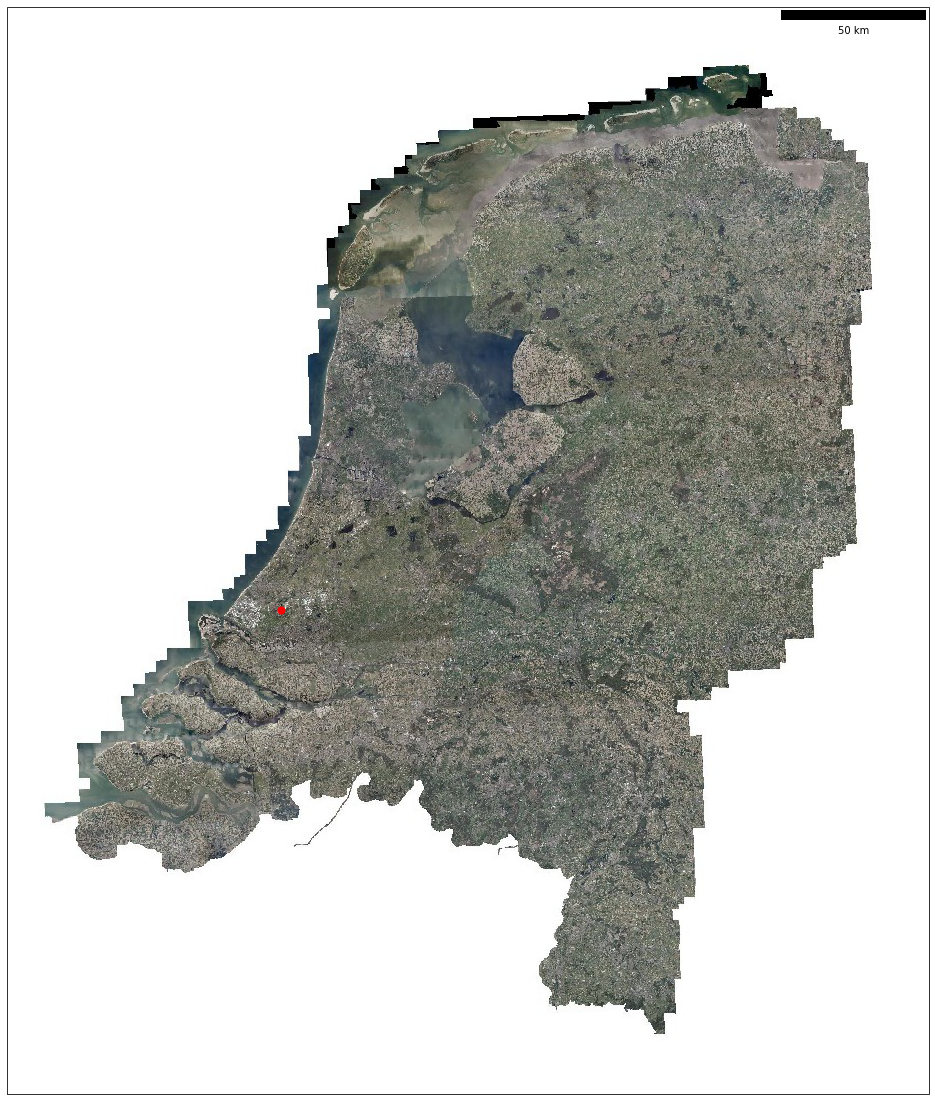

In [3]:
# Create figure
fig = plt.figure(figsize=(20, 20))
# Define projection system
crs = ccrs.epsg(32631)
# Define Netherlands extent
extent = [3, 7.5, 50.5, 53.8] # with (x0, x1, y0, y1) of the map in the given coordinate system.
# Create plot
ax = plt.axes(projection=crs)
# Set extent
ax.set_extent(extent)
# Add PDOK WMS
ax.add_wms(wms='https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0',layers=['Actueel_ortho25'])

# Add scalebar
scalebar = ScaleBar(1,box_alpha=0)
ax.add_artist(scalebar)
# Add red dot
 
ax.plot(4.3797773014219255,51.999755164705995, 'ro', markersize=7, transform=ccrs.Geodetic())


In [4]:
# Create figure
fig = plt.figure(figsize=(20, 20))
# Define projection system
crs = ccrs.epsg(32631)
# Define Netherlands extent
extent = [3, 7.5, 50.5, 53.8] # with (x0, x1, y0, y1) of the map in the given coordinate system.
# Create plot
ax = plt.axes(projection=crs)
# Set extent
ax.set_extent(extent)
# Add MODIS reflectance WMS
ax.add_wms(wms='https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi',layers=['MODIS_Aqua_CorrectedReflectance_TrueColor'],wms_kwargs={'time':'2021-09-05'})
# Add scalebar
scalebar = ScaleBar(1,box_alpha=0,color='white')
ax.add_artist(scalebar)

In [ ]:
print(ahn)

NameError: name 'ahn' is not defined

In [ ]:
# Create figure
fig = plt.figure(figsize=(20, 20))

# Get data from GEE
ahn = ee.Image('AHN/AHN2_05M_INT');
# select elevation layer
elevation = ahn.select('elevation')
# Define region
region = [3,50.5,7.5,53.8]
# Define projection system
crs = ccrs.epsg(32631)
# define visualization parameters for image
vis = {'min':0,'max':40} 

# use cartoee to get a map
ax = cartoee.get_map(elevation,region=region,vis_params=vis,proj=crs)

# convert bbox coordinate from [W,S,E,N] to [W,E,S,N] as matplotlib expects
zoom_extent = cartoee.bbox_to_extent(region)

# set the extent of the map to the zoom area
ax.set_extent(zoom_extent,ccrs.PlateCarree())

# Add scalebar
scalebar = ScaleBar(1,box_alpha=0,color='red')
ax.add_artist(scalebar)


In [ ]:
# Create Map
Map = geemap.Map()
# Add PDOK WMS
pd_url = 'https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0'
Map.add_wms_layer(url=pd_url,layers='Actueel_ortho25',name='PDOK',shown=True)
Map.add_wms_layer('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi',layers='MODIS_Aqua_CorrectedReflectance_TrueColor')
# Center and zoom on the Netherlands
Map.setCenter(lat=52,lon=5,zoom=8)
Map

# Week 2

## images

1. Load the latest Sentinel-2 surface reflectance image over your home

In [146]:
house_coords = [52.00667, 4.35556]
box_size= 0.1
bbox_coord = [house_coords[1]-box_size,house_coords[0]-box_size,house_coords[1]+box_size,house_coords[0]+box_size]
pt_hs = ee.Geometry.Point(coords=[3.966064,51.699800])
bbox_geom = ee.Geometry.BBox(*bbox_coord)
start = ee.Date('2021-08-01')
enddate = ee.Date('2021-09-04')

In [148]:
collection = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(start,enddate).filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',50).filterBounds(bbox_geom).sort('CLOUDY_PIXEL_PERCENTAGE')
image = collection.first()
image_first = collection.reduce(ee.Reducer.first()).select('B4_first','B3_first','B2_first',)

2. Print the image information: what is the date, projection, cloud cover?bbox_geom

In [149]:
metadata = image.getInfo()

In [150]:
cc_prc = metadata['properties']['CLOUDY_PIXEL_PERCENTAGE']
prj = metadata['bands'][0]['crs']
id_ = metadata['id']
print(f'Cloud cover percentage: {cc_prc}')
print(f'Projection is {prj}')
print(f'Image ID is {id_}')



Cloud cover percentage: 23.113294
Projection is EPSG:32631
Image ID is COPERNICUS/S2_SR/20210803T105031_20210803T105327_T31UET


3. Visualize a true color image with Red, Green, Blue bands

In [151]:
minv,maxv = 0,6500

In [152]:
m = geemap.Map(center=house_coords,zoom=18)
vizParams = {'bands': ['B4', 'B3', 'B2'],
             'min': minv, 'max': maxv, }
m.centerObject(image, 9)
m.addLayer(image,vis_params=vizParams,name='Surface reflectance',shown=True)
m

Map(center=[51.85423852486509, 3.796652567602063], controls=(WidgetControl(options=['position', 'transparent_b…

In [94]:
vizParams = {'bands': ['B4_first', 'B3_first', 'B2_first'],
             'min': minv, 'max': maxv, 'gamma': 1.3}
#m.centerObject(image_first, 9)
m.addLayer(image_first,vis_params=vizParams,name='Surface reflectance_first',shown=True)


In [465]:
median = collection.reduce(ee.Reducer.median())
# Define visualization parameters in an object literal.
vizParams = {'bands': ['B4_median', 'B3_median', 'B2_median'],
             'min': minv, 'max': maxv, 'gamma': 1.3}

m.addLayer(median, vizParams, 'Median Image')
m.layer_control
m

Map(center=[52.00667, 4.35556], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

4. Adjust the visualisation scaling parameters to see the effect on the parameters

5. Add a false colour composite with NIR, Red, Green

In [473]:
collection = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(start,enddate).filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',30).filterBounds(bbox_geom).sort('CLOUDY_PIXEL_PERCENTAGE')
nir = collection.reduce(ee.Reducer.first()).select('B8_first','B4_first','B3_first',)

In [477]:
m = geemap.Map(center=house_coords,zoom=18)
vizParams = {'bands': ['B8_first','B3_first','B2_first',],
             'min': minv, 'max': maxv, 'gamma': 1.3}
m.centerObject(image, 9)
m.addLayer(nir,vis_params=vizParams,name='Surface reflectance',shown=True)
m

EEException: Image.visualize: No band named 'B2_first'. Available band names: [B8_first, B4_first, B3_first].

6. Add the cloud probability band (‘MSK_CLDPRB’) with a pseudocolor palette from colorBrewer

In [133]:
collection = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(start,enddate).filterBounds(bbox_geom)
cl_prb = collection.reduce(ee.Reducer.median())
#.select('MSK_CLDPRB_first',)
m = geemap.Map(center=house_coords,zoom=10)

# Define visualization parameters in an object literal.
vizParams = {'bands': ['MSK_CLDPRB',],
             'min': 0, 'max': 100,
             'palette':['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'],
            }

m.addLayer(image, vizParams, 'cloud prob',)
m.layer_control
m

Map(center=[52.00667, 4.35556], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

7. Add the RGB image with clouds (MSK_CLDPRB>50%) masked

In [143]:
cld_prb = image.select('MSK_CLDPRB').lt(50)
im2 = image.updateMask(cld_prb)

In [155]:
m = geemap.Map(center=house_coords)
vizParams = {'bands': ['B4', 'B3', 'B2'],
             'min': minv, 'max': maxv, }
m.centerObject(im2, 9)
m.addLayer(im2,vis_params=vizParams,name='SR mask',shown=True)
m

Map(center=[51.85423852486509, 3.796652567602063], controls=(WidgetControl(options=['position', 'transparent_b…

## collections

In [3]:
house_coords = [52.00667, 4.35556]
box_size= 1
bbox_coord = [house_coords[1]-box_size,house_coords[0]-box_size,house_coords[1]+box_size,house_coords[0]+box_size]
pt_hs = ee.Geometry.Point(coords=[3.966064,51.699800])
bbox_geom = ee.Geometry.BBox(*bbox_coord)
start = ee.Date('2019-01-01')
enddate = ee.Date('2021-09-04')
minv,maxv = 0,6500

In [4]:
collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(bbox_geom).filterDate(start,enddate).filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',50)
mean_im = collection.mean()
med_im = collection.median()
collection = collection.map(lambda x:x.addBands(x.select('MSK_CLDPRB').multiply(-1),overwrite=True))
qm = collection.qualityMosaic('MSK_CLDPRB')
metadata = mean_im.getInfo()


In [27]:
med_im.updateMask(med_im.select('QA60'))

In [25]:
m = geemap.Map(center=house_coords,zoom=10)
vizParams = {'bands': ['B4', 'B3', 'B2'],
             'min': minv, 'max': maxv, }

m.addLayer(med_im,vis_params=vizParams,shown=True,name='median')
vizParams = {'bands': ['B4', 'B3', 'B2'],
             'min': minv, 'max': maxv, }

m.addLayer(qm,vis_params=vizParams,shown=True,name='Quality Mosaic')
vizParams = {'bands': ['MSK_CLDPRB',],
             'min': 0, 'max': 100,
             'palette':['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#990000'],
            }
#m.addLayer(qm.select('MSK_CLDPRB'),vis_params=vizParams,shown=True,name='cld prob')
m

Map(center=[52.00667, 4.35556], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

Exercise
1. Calculate the NDVI for every cloud free (<20%) Sentinel-2 image since 2019 and visualise the mean

In [12]:
house_coords = [52.00667, 4.35556]
box_size= 1
bbox_coord = [house_coords[1]-box_size,house_coords[0]-box_size,house_coords[1]+box_size,house_coords[0]+box_size]
pt_hs = ee.Geometry.Point(coords=[3.966064,51.699800])
bbox_geom = ee.Geometry.BBox(*bbox_coord)
start = ee.Date('2017-01-01')
enddate = ee.Date('2021-09-04')
minv,maxv = 0,6500

In [13]:
collection = ee.ImageCollection('COPERNICUS/S2_SR').filterDate(start,enddate).filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',20)
ndvi_col = collection.map(lambda x: x.normalizedDifference(bandNames=['B8','B4'],))
ndvi_mean = ndvi_col.mean()


In [14]:
m = geemap.Map(center=house_coords,zoom=10)
vizParams = {'bands': ['nd'],
             'min': -1, 'max': 1, }

m.addLayer(ndvi_mean,vis_params=vizParams,shown=True,name='NDVI-mean')

m

Map(center=[52.00667, 4.35556], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

2. Apply the QA60 cloud mask and repeat 1

In [31]:
collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(bbox_geom)
collection = collection.map(lambda x:x.updateMask(x.select('QA60')))

In [32]:
ndvi_col = collection.map(lambda x: x.normalizedDifference(bandNames=['B8','B4'],))
ndvi_mean = ndvi_col.mean()

In [33]:
m = geemap.Map(center=house_coords,zoom=10)
vizParams = {'bands': ['nd'],
             'min': -1, 'max': 1, }
m.addLayer(ndvi_mean,vis_params=vizParams,shown=True,name='NDVI-mean')
m

Map(center=[52.00667, 4.35556], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(ch…

3. Repeat 2 and apply it for every year since beginning.

# Week 3

In [3]:
ruw = ee.Image("AHN/AHN2_05M_RUW")
int_ = ee.Image("AHN/AHN2_05M_INT")
non = ee.Image("AHN/AHN2_05M_NON")

In [31]:
# opening and closing operations
kernel = ee.Kernel.circle(radius=2,units='meters',normalize=True)

int_close = int_.focal_max(kernel=kernel).focal_min(kernel=kernel)
int_open = int_.focal_min(kernel=kernel).focal_max(kernel=kernel)
ruw_close = ruw.focal_max(kernel=kernel).focal_min(kernel=kernel)
ruw_open = ruw.focal_min(kernel=kernel).focal_max(kernel=kernel)

In [37]:
m = geemap.Map(center=[52.0466789784515,4.336818309033044],zoom=15)
vp = {'min':-5,'max':30,'palette':['fdfecc', 'a5dfa7', '5dbaa4', '488e9e', '3e6495', '3f396c', '281a2c']}
m.addLayer(ruw,vis_params=vp,name='ruw')
m.addLayer(int_,vis_params=vp,name='int')
m.addLayer(non,vis_params=vp,name='non')
m.addLayer(int_close,vis_params=vp,name='Int Closed')
m.addLayer(int_open,vis_params=vp,name='Int open')
m.addLayer(ruw_close,vis_params=vp,name='ruw Closed')
m.addLayer(ruw_open,vis_params=vp,name='Ruw Open')
m

Map(center=[52.0466789784515, 4.336818309033044], controls=(WidgetControl(options=['position', 'transparent_bg…